# Plate recognition 
![alt text](https://i.ytimg.com/vi/nmDiZGx5mqU/hqdefault.jpg)

**Deadline:** September 14th 23:55<br>
**Submission format:** .ipynb file with solution

In this homework you will try to recognize russian plate number. You can use any method for symbol recognition (CNN, some classic algorithm or Tessaract). But you cant use Tessaract for full plate recognition! Only symbol recognition. The main concept is:


1. Undistort plate (you will have 4 points of plate)
2. Perform segmentation by yourself
3. Recognize symbols
4. Concatenate recognized symbols



### Preparations

In [1]:
# Import libraries
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
# set inline plots size
plt.rcParams["figure.figsize"] = (15, 14) # (w, h)
import numpy as np
import cv2
from skimage.transform import resize
import scipy.ndimage as ndimage


In [2]:
def show_in_row(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

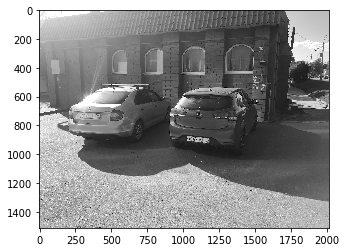

In [3]:
img_gray = cv2.imread("russian_plate_recog.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img_gray, cmap = 'gray')
plt.show()

In [4]:
plate_points_1 = np.array([[1028, 874], [1184, 890], [1184, 924], [1027, 906]], np.int32)
plate_points_2 = np.array([[293, 714], [422, 719], [421, 749], [291, 743]], np.int32)

## Step 1 -> Undistort

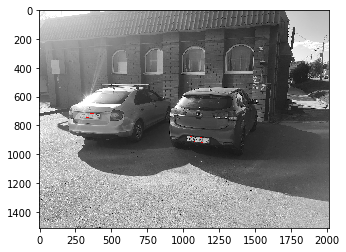

In [5]:
# just draw plate borders on image
from skimage.io import imread
from skimage.filters import threshold_otsu

check_bgr = cv2.imread("russian_plate_recog_gray.jpg", cv2.IMREAD_COLOR)
check_rgb = cv2.cvtColor(check_bgr, cv2.COLOR_BGR2RGB)

#draw polylines
cv2.polylines(check_rgb, [plate_points_1], True, (255,0,0))
cv2.polylines(check_rgb, [plate_points_2], True, (255,0,0))

plt.imshow(check_rgb)
plt.show()

In [6]:
def maximizeContrast(imgGrayscale):

    height, width = imgGrayscale.shape

    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)

    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    return imgGrayscalePlusTopHatMinusBlackHat

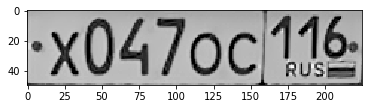

In [7]:
image_rgb = cv2.cvtColor(check_bgr, cv2.COLOR_BGR2RGB)

# findHomography and warpPerspective may help you
pts = np.array([ [0,0], [225, 0], [225, 50], [0, 50]], np.int32 )
# findHomography
h, status = cv2.findHomography(plate_points_1, pts)
# warpPerspective
first_number_img = cv2.warpPerspective(image_rgb, h, (225,50))


first_number_img_gray = cv2.cvtColor(first_number_img, cv2.COLOR_RGB2GRAY)
first_number_img_gray = cv2.bilateralFilter(first_number_img_gray, 11, 17, 17)
first_number_img_gray = maximizeContrast(first_number_img_gray)

plt.imshow(first_number_img_gray, cmap = 'gray')


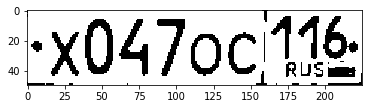

In [8]:
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

threshold_value = threshold_otsu(first_number_img_gray)
binary_img_number = first_number_img_gray > threshold_value
plt.imshow(binary_img_number, cmap='gray')

## Checkpoint 1
Expected result:

![alt text](https://drive.google.com/uc?export=view&id=1xNKKcR-KYeqfwLKAHmAdetsFRHL9VOHY)

---
## Step 2 -> Segmentation

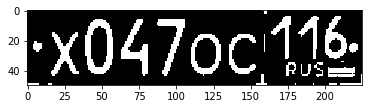

In [9]:
# Apply the thresholding
a = first_number_img_gray.max()  
_, thresh = cv2.threshold(first_number_img_gray, 95, a, cv2.THRESH_BINARY_INV)

plt.imshow(thresh, cmap = 'gray')


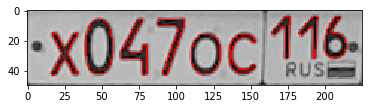

In [10]:
# findContours and minAreaRect may help you
def filter_contours(contours, hierarchy_temp, count):
    contours_filtered = []
    for i in range(len(contours)):
        # remove contours inside others
        if hierarchy_temp[0,i,3] == -1:
            contours_filtered.append(contours[i])
    # remove unnecessary/small contours
    
    contours_filtered = sorted(contours_filtered, key = cv2.contourArea, reverse = True)[:count] 
    # sort from left to right
    contours_filtered = sorted(contours_filtered, key = lambda ctr: cv2.boundingRect(ctr)[0] )

    return contours_filtered

contours, hierarchy = cv2.findContours(
                                   image = thresh, 
                                   mode = cv2.RETR_TREE, 
                                   method = cv2.CHAIN_APPROX_SIMPLE)
contours = filter_contours(contours,hierarchy, 9)

img_copy = first_number_img.copy()
cv2.drawContours(img_copy, contours, -1, (255, 0, 0))
plt.imshow(img_copy)


True

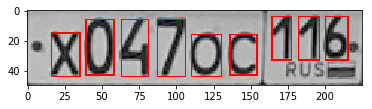

In [11]:
for contour in contours:
    # Draw a straight rectangle with the points
    x, y, w, h = cv2.boundingRect(contour)
    img_box = cv2.rectangle(first_number_img, (x, y), (x+w, y+h), color = (255, 0, 0), thickness = 1)
    

    plt.imshow(first_number_img)
cv2.imwrite("test.jpg",first_number_img)

## Checkpoint 2
Expected result:

![alt text](https://drive.google.com/uc?export=view&id=1nqP1g3VDctRfjBA6YV0A1OV3HF2FIEes)

---
## Step 3 -> Recognition

In [12]:
def add_padding(image, bordersize):
    row, col= image.shape[:2]
    bottom= image[row-2:row, 0:col]
    mean= cv2.mean(bottom)[0]
    return cv2.copyMakeBorder(image, top=bordersize, bottom=bordersize, left=bordersize, right=bordersize, borderType= cv2.BORDER_CONSTANT, value=[0,0,0] )


In [13]:
# CNN can help you recognize letters. You can use any CNN that you find in internet. 
# Or train your own. 
# EMNIST(Extended MNIST) dataset may be helpfull.

characters = []
images_of_characters = []
for index in range(len(contours)):
    c_0 = contours[index]
    # Get the 4 points of the bounding rectangle
    x, y, w, h = cv2.boundingRect(c_0)
    crop_img = thresh[y-2:y+h+2, x-2:x+w+2]
    crop_img = cv2.resize(crop_img, (25, 25))
   
   
    
    # add paddding
    crop_img = add_padding(crop_img, 5)
    _, crop_img = cv2.threshold(crop_img, 120, 255, cv2.THRESH_BINARY_INV)

    kernel   = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    crop_img = cv2.morphologyEx(crop_img, cv2.MORPH_CLOSE, kernel, iterations=4)

    crop_img = cv2.dilate(crop_img,kernel,iterations = 5)

    characters.append(crop_img)
    images_of_characters.append(crop_img)
    cv2.imwrite(str(index)+'.jpg',crop_img)


Result is XO47OCA46


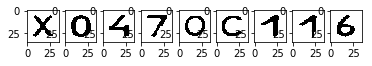

In [14]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'
recognized_number = ''
def img_to_text(image):
    text = pytesseract.image_to_string(image , config='--psm 10')  
    return text[0]

for index in range(len(characters)):
    recognized_number += img_to_text(characters[index])

print('Result is ' + recognized_number.upper())
show_in_row(images_of_characters)


## Checkpoint 3
Expected result:

![alt text](https://drive.google.com/uc?export=view&id=1gb5xIGBTAadyqcrZzNC0I4VM3KAhjkF7)

---
## Step 4 -> Concatenation
The 'o' symbol hard to distinct with '0'(Zero) symbol. It's okay if you get zero or 'o' on second and fifth place. Expected result: 
> **x0470c116**

Also try second plate on image to recognize. If you current solution doesn't work, think about how to fix it.

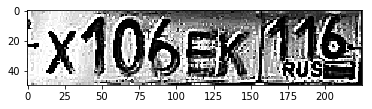

In [15]:

# if you done all before, this is easiest part =)
image_rgb = cv2.cvtColor(check_bgr, cv2.COLOR_BGR2RGB)

# findHomography and warpPerspective may help you
pts = np.array([ [0,0], [225, 0], [225, 50], [0, 50]], np.int32 )
# findHomography
h, status = cv2.findHomography(plate_points_2, pts)
# warpPerspective
second_number_img_gray = cv2.warpPerspective(image_rgb, h, (225,50))

orig = cv2.warpPerspective(image_rgb, h, (225,50))
second_number_img_gray = cv2.cvtColor(second_number_img_gray, cv2.COLOR_RGB2GRAY)
second_number_img_gray = cv2.bilateralFilter(second_number_img_gray, 11, 17, 17)
second_number_img_gray = maximizeContrast(second_number_img_gray)

kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
second_number_img_gray = cv2.equalizeHist(second_number_img_gray)
second_number_img_gray = cv2.filter2D(second_number_img_gray, -1, kernel)


plt.imshow(second_number_img_gray, cmap = 'gray')

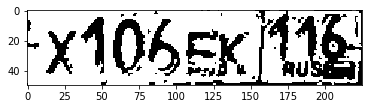

In [16]:
# Apply the thresholding
a = second_number_img_gray.max()  
_, thresh_2 = cv2.threshold(second_number_img_gray.copy(), 35, a, cv2.THRESH_BINARY)
thresh_2 = cv2.GaussianBlur(thresh_2,(3,3),0)
ret3,thresh_2 = cv2.threshold(thresh_2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh_2, cmap = 'gray')

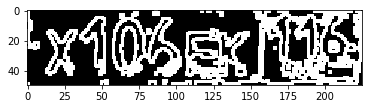

In [17]:
kernel = np.ones((3,3),np.uint8)
thresh_2 = cv2.morphologyEx(thresh_2, cv2.MORPH_GRADIENT, kernel)
plt.imshow(thresh_2, cmap = 'gray')

True

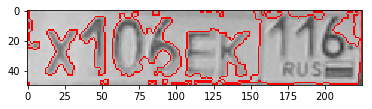

In [18]:

contours_2, hierarchy_2 = cv2.findContours(
                                   image = thresh_2, 
                                   mode = cv2.RETR_TREE, 
                                   method = cv2.CHAIN_APPROX_SIMPLE)
contours_2 = filter_contours(contours_2, hierarchy_2, 20)

img_copy = second_number_img_gray.copy()
cv2.drawContours(orig, contours_2, -1, (255, 0, 0))
plt.imshow(orig)
cv2.imwrite("test2.jpg",img_copy)